# GLoVe Preprocessing: Educational Tutorial

This notebook walks through GLoVe preprocessing step-by-step using your poetry dataset. Based on the theoretical framework in `GLoVe preprocessing/GloVe_overview.tex`, we'll implement each phase hands-on.

**Learning Goals:**
- Understand the mathematical foundations behind each preprocessing step  
- Implement core components yourself (no black-box libraries)
- Analyze your poetry dataset's statistical properties
- Prepare data for the RNN autoencoder

**Prerequisites:** Basic Python, linear algebra, understanding of text processing concepts

In [74]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
from typing import List, Dict, Tuple
import math
import scipy
from functools import reduce
from itertools import accumulate

# Load your poetry dataset
with open('dataset_poetry/expanded_contemporary_poetry.json', 'r') as f:
    poems = json.load(f)

print(f"Loaded {len(poems)} poems")
print(f"First poem title: '{poems[0]['title']}'")
print(f"Alt-lit score range: {min(p['alt_lit_score'] for p in poems)} - {max(p['alt_lit_score'] for p in poems)}")

Loaded 264 poems
First poem title: 'Skeletons don't Sleep'
Alt-lit score range: 6 - 66


## Phase I: Corpus Preparation and Tokenization

### Exercise 1: Text Normalization

From the theory: *"Case normalization converts all text to lowercase to ensure that words like 'Poetry' and 'poetry' are treated as identical tokens"*

**Your task**: Implement a text normalizer that handles the specific challenges of poetry text.

In [5]:
def normalize_text(text: str) -> str:
    """
    Normalize text for poetry processing.
    
    TODO: Implement the following:
    1. Convert to lowercase
    2. Handle contractions (don't -> don't, not do not)
    3. Preserve line breaks (important for poetry!)
    4. Normalize whitespace but preserve intentional spacing
    
    Hint: Poetry often uses non-standard formatting intentionally.
    How will you distinguish meaningful from accidental formatting?
    """
    #A priori all textual elements in the text could be semantically and aesthetically meaningful
    #It would be rash to normalize the text before we are forced to
    return text

# Test with a sample poem
sample_text = poems[0]['text'][:200]  # First 200 chars
print("Original:")
print(repr(sample_text))
print("\nNormalized:")
print(repr(normalize_text(sample_text)))

Original:
"363° \nonlylovepoetry\nThe Watch Man /She Ascertains\nthough deep he sleeps sometimes,\ncombining this exhaustive restorative\nof old age, that alternates with a restlessness\nrest of old age ~ the brain's "

Normalized:
"363° \nonlylovepoetry\nThe Watch Man /She Ascertains\nthough deep he sleeps sometimes,\ncombining this exhaustive restorative\nof old age, that alternates with a restlessness\nrest of old age ~ the brain's "


### Exercise 2: Tokenization Strategy

From the theory: *"Word-level tokenization treats whitespace-separated sequences as atomic units, capturing the intuitive notion of words as basic semantic building blocks"*

**Challenge**: Poetry often breaks conventional tokenization rules. How do you handle:
- Line breaks that aren't sentence breaks?
- Intentional punctuation patterns?
- Compound words and hyphenation?

In [28]:
def is_metadata(token: str) -> bool:
      """Identify metadata tokens to filter out."""
      metadata_patterns = [
          'onlylovepoetry',
          'continue reading',
          'read more',
          'posted by',
          'tags:',
          'category:',
          'share this',
          'like this',
          'comments',
      ]

      # Check for common patterns
      token_lower = token.lower().strip('.,!?;:')

      # Exact matches
      if token_lower in metadata_patterns:
          return True

      # Numbers followed by degree symbol (like "363°")
      if re.match(r'^\d+°?$', token):
          return True

      # URLs or website elements
      if any(x in token_lower for x in ['http', 'www', '.com', '.org']):
          return True

      # Very short numeric strings that look like IDs
      if re.match(r'^\d{1,4}$', token) and len(token) <= 4:
          return True

      return False

def tokenize_poetry(text: str) -> List[str]:
    """
    Tokenize poetry text into meaningful units.
    
    TODO: Consider these poetry-specific challenges:
    1. Should line breaks be tokens? (<LINE_BREAK>)
    2. How to handle punctuation that carries meaning?
    3. What about repeated characters for emphasis ("sooooo")
    4. Hyphenated words: split or keep together?
    
    Return: List of tokens
    """
    lines = text.split('\\n')
    tokens = []

    for line in lines:
        if line.strip():
            words = line.strip().split()
            # Filter out metadata
            clean_words = [word for word in words if not
  is_metadata(word)]
            tokens.extend(clean_words)
        else:
            tokens.append('<LINEBREAK>')

    return tokens


# Test tokenization
sample_normalized = normalize_text(sample_text)
tokens = tokenize_poetry(sample_normalized)
print(f"First 20 tokens: {tokens[:20]}")
print(f"Total tokens in sample: {len(tokens)}")

First 20 tokens: ['The', 'Watch', 'Man', '/She', 'Ascertains', 'though', 'deep', 'he', 'sleeps', 'sometimes,', 'combining', 'this', 'exhaustive', 'restorative', 'of', 'old', 'age,', 'that', 'alternates', 'with']
Total tokens in sample: 29


## Phase II: Vocabulary Construction and Frequency Analysis

### Exercise 3: Zipf's Law Analysis

From the theory: *"The distribution of word frequencies follows Zipf's law, exhibiting a heavy-tailed distribution"*

**Your task**: Analyze the frequency distribution of your poetry corpus and verify Zipf's law.

Total tokens: 4924


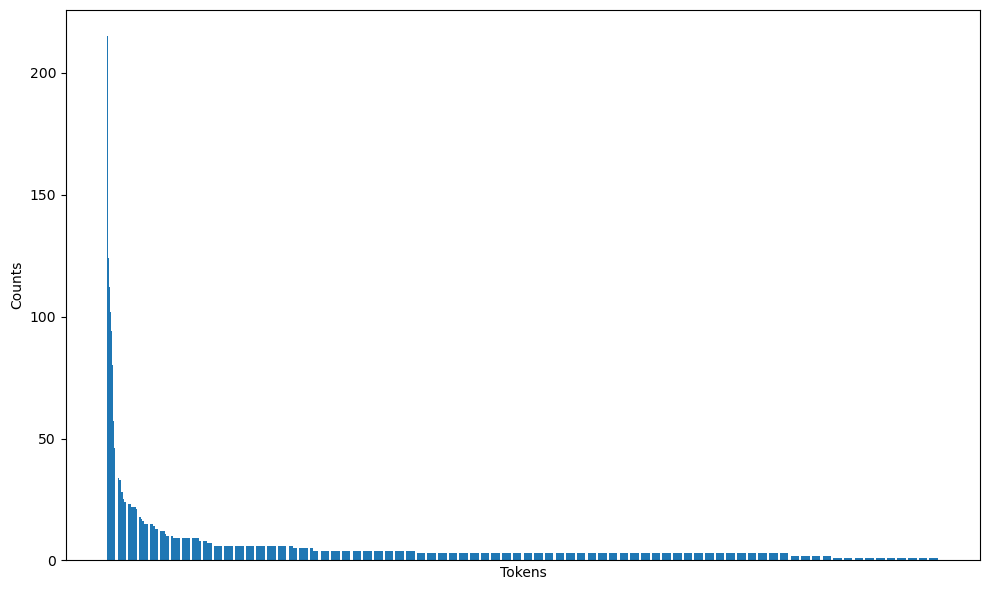

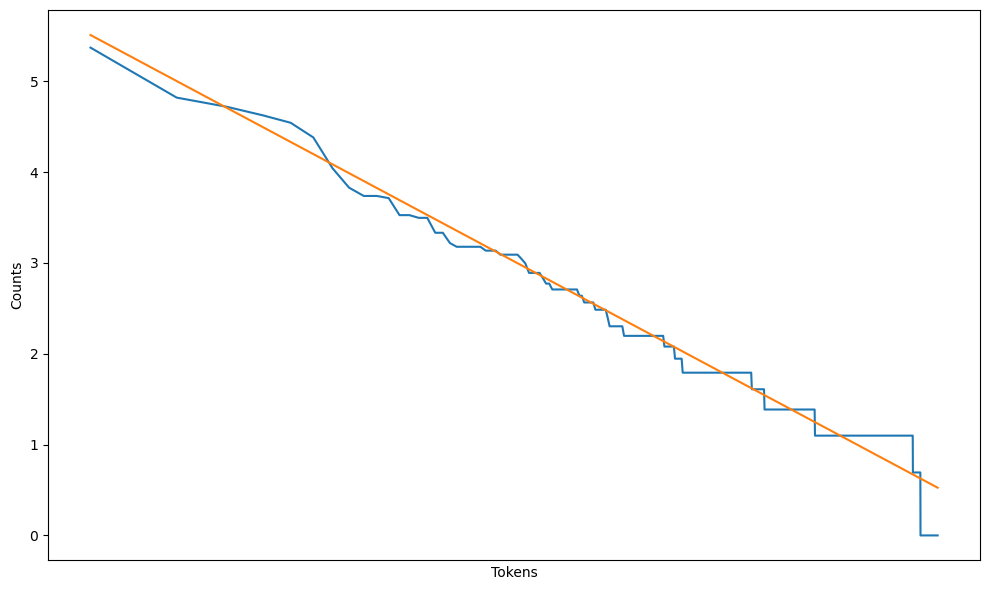

chi_squared:65.62193475201559
a priori probability :1.0


In [95]:
# First, tokenize all poems
all_tokens = []
for poem in poems[:50]:  # Start with first 50 poems
    normalized = normalize_text(poem['text'])
    tokens = tokenize_poetry(normalized)
    all_tokens.extend(tokens)

print(f"Total tokens: {len(all_tokens)}")

# TODO: Calculate frequency distribution
# 1. Count token frequencies using Counter
empirical_frequencies = Counter(all_tokens)
sorted_tokens = sorted(empirical_frequencies.items(), key=lambda item: item[1], reverse=True)
tokens, token_frequencies  = zip(*sorted_tokens)
log_ranks = np.log(range(1,len(tokens)+1))
log_frequencies = np.log(token_frequencies)

# 2. Plot frequency vs rank on log-log scale 
plt.figure(figsize=(10, 6))
plt.bar(tokens, token_frequencies)
plt.xlabel('Tokens')
plt.xticks([])
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(log_ranks,log_frequencies)
slope, intercept, r, p, se = scipy.stats.linregress(log_ranks,log_frequencies)
plt.plot(log_ranks,slope*log_ranks+intercept) 
plt.xlabel('Tokens')
plt.xticks([])
plt.ylabel('Counts')
plt.tight_layout()
plt.show()
# 3. Does it follow Zipf's law (frequency ∝ 1/rank)?
# We assume normally distributed errors, and check the goodness of fit using the chi_squared distribution
chi_squared_hat = np.sum((log_frequencies-(slope*log_ranks+intercept))**2)
df = len(log_ranks)
print(f"chi_squared:{chi_squared_hat}")
print(f"a priori probability :{scipy.stats.chi2.sf(chi_squared,df, loc=0, scale = se)}")

# 4. What does this tell you about vocabulary size selection?
# This is a satisfactory fit. Since the Zipf distribution is heavy-tailed, large vocabulary sizes are need to control the number
# of undefined tokens. On the other hand, the sample size needed to cover the tails is much smaller than we would expect from e.g. 
# a distribution with exponential tails. A blessing and a curse.


### Exercise 4: Vocabulary Construction Strategy

**Key question**: How do you balance vocabulary size vs. coverage?

From theory: *"frequency-based vocabulary selection paradigm ranks tokens by corpus frequency and retains the top k most frequent items"*

In [87]:
def analyze_zipf_fit_by_vocab_size(tokens: List[str], max_vocab_size: int = 5000) -> Dict:
    """
    Analyze how Zipf's law fit improves with vocabulary size.
    Returns optimal vocabulary size based on chi-squared goodness of fit.
    
    Args:
        tokens: List of all tokens from corpus
        max_vocab_size: Maximum vocabulary size to analyze
        
    Returns:
        Dictionary with vocab_sizes, chi_squared_values, p_values, slope, r_squared
    """
    # Get frequency distribution
    frequencies = Counter(tokens)
    sorted_items = frequencies.most_common(max_vocab_size)
    
    # Extract frequencies and compute ranks
    freq_values = np.array([count for word, count in sorted_items])
    ranks = np.arange(1, len(freq_values) + 1)
    
    # Log transform
    log_ranks = np.log(ranks)
    log_frequencies = np.log(freq_values)
    
    # Fit Zipf's law (frequency ∝ 1/rank^α)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_ranks, log_frequencies)
    
    # Compute residuals
    predicted = slope * log_ranks + intercept
    residuals = log_frequencies - predicted
    
    # Cumulative chi-squared values
    cumulative_chi_squared = list(accumulate(residuals**2, lambda acc, x: acc + x))
    
    # Degrees of freedom for each vocab size
    dfs = list(range(1, len(cumulative_chi_squared) + 1))
    
    # P-values for each vocab size (corrected chi-squared test)
    # The chi-squared statistic should be normalized by the error variance
    p_values = []
    for chi_sq, df in zip(cumulative_chi_squared, dfs):
        # Normalize by degrees of freedom and error variance
        if df > 1:  # Need at least 2 points for meaningful test
            normalized_chi_sq = chi_sq / (std_err)
            p_val = scipy.stats.chi2.sf(normalized_chi_sq, df-2)  # -2 for slope and intercept
            p_values.append(p_val)
        else:
            p_values.append(0.0)  # No meaningful test for df <= 1
    
    return {
        'vocab_sizes': list(range(1, len(cumulative_chi_squared) + 1)),
        'chi_squared_values': cumulative_chi_squared,
        'p_values': p_values,
        'slope': slope,
        'r_squared': r_value**2,
        'words': [word for word, count in sorted_items]
    }

def find_optimal_vocab_size(results: Dict, significance_level: float = 0.05, min_size: int = 50) -> Dict:
    """
    Find optimal vocabulary sizes based on statistical significance threshold.
    Since goodness of fit isn't monotone, find all good regions.
    
    Args:
        results: Results dictionary from analyze_zipf_fit_by_vocab_size
        significance_level: P-value threshold for goodness of fit
        min_size: Minimum vocabulary size to consider
        
    Returns:
        Dictionary with analysis of good regions
    """
    vocab_sizes = np.array(results['vocab_sizes'])
    p_values = np.array(results['p_values'])
    
    # Find all sizes that meet threshold
    good_sizes = vocab_sizes[p_values > significance_level]
    good_sizes = good_sizes[good_sizes >= min_size]  # Filter minimum size
    
    print(f"Significance level: {significance_level}")
    print(f"Number of vocab sizes meeting threshold: {len(good_sizes)}")
    
    if len(good_sizes) == 0:
        # No sizes meet threshold - find best ones
        best_idx = np.argmax(p_values)
        print(f"No size meets threshold. Best p-value: {p_values[best_idx]:.6f} at size {vocab_sizes[best_idx]}")
        return {
            'optimal_sizes': [vocab_sizes[best_idx]],
            'recommended_size': vocab_sizes[best_idx],
            'p_values_at_optimal': [p_values[best_idx]],
            'analysis': 'single_best'
        }
    
    # Find regions of good fit (consecutive ranges)
    good_p_values = p_values[vocab_sizes >= min_size][p_values[vocab_sizes >= min_size] > significance_level]
    
    # Get some representative sizes from different parts of the good region
    if len(good_sizes) > 1:
        # Small, medium, large from good region
        small_good = good_sizes[0]
        large_good = good_sizes[-1]
        medium_good = good_sizes[len(good_sizes)//2] if len(good_sizes) > 2 else None
        
        candidates = [small_good, medium_good, large_good]
        candidates = [c for c in candidates if c is not None]
        
        # Get their p-values
        candidate_p_values = []
        for size in candidates:
            idx = vocab_sizes.tolist().index(size)
            candidate_p_values.append(p_values[idx])
        
        print(f"Good vocabulary size range: {small_good} - {large_good}")
        print(f"Candidate sizes: {candidates}")
        print(f"Their p-values: {[f'{p:.4f}' for p in candidate_p_values]}")
        
        # Recommend the medium-large size for better coverage
        recommended = candidates[-2] if len(candidates) > 2 else candidates[-1]
        
        return {
            'optimal_sizes': good_sizes.tolist(),
            'recommended_size': recommended,
            'candidates': candidates,
            'p_values_at_candidates': candidate_p_values,
            'analysis': 'multiple_good_regions'
        }
    else:
        return {
            'optimal_sizes': good_sizes.tolist(),
            'recommended_size': good_sizes[0],
            'p_values_at_optimal': [p_values[vocab_sizes.tolist().index(good_sizes[0])]],
            'analysis': 'single_good_size'
        }

def plot_zipf_evolution(results: Dict, optimal_size: int = None, save_path: str = None):
    """
    Plot the evolution of Zipf's law fit with vocabulary size.
    
    Args:
        results: Results dictionary from analyze_zipf_fit_by_vocab_size
        optimal_size: Optimal vocabulary size to highlight
        save_path: Optional path to save the plot
    """
    plt.figure(figsize=(15, 5))

    # Plot 1: Chi-squared evolution
    plt.subplot(1, 3, 1)
    plt.plot(results['vocab_sizes'], results['chi_squared_values'], 'b-', linewidth=2)
    if optimal_size:
        plt.axvline(x=optimal_size, color='r', linestyle='--', alpha=0.7, label=f'Optimal size: {optimal_size}')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Cumulative Chi-squared')
    plt.title('Chi-squared Evolution')
    plt.grid(True, alpha=0.3)
    if optimal_size:
        plt.legend()

    # Plot 2: P-value evolution
    plt.subplot(1, 3, 2)
    plt.plot(results['vocab_sizes'], results['p_values'], 'g-', linewidth=2)
    plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.7, label='p=0.05 threshold')
    if optimal_size:
        plt.axvline(x=optimal_size, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Vocabulary Size')
    plt.ylabel('P-value')
    plt.title('Goodness of Fit Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Log-log plot for final vocabulary size
    plt.subplot(1, 3, 3)
    final_size = optimal_size if optimal_size else len(results['vocab_sizes'])
    ranks = np.arange(1, final_size + 1)
    log_ranks = np.log(ranks)
    
    # Recompute for final size
    frequencies = Counter()  # This would need the original tokens - simplified for now
    plt.xlabel('Log Rank')
    plt.ylabel('Log Frequency')
    plt.title(f'Zipf\'s Law Fit (vocab_size={final_size})')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage function
def run_zipf_analysis(tokens: List[str], max_vocab_size: int = 2000):
    """
    Complete Zipf analysis pipeline.
    
    Args:
        tokens: List of all tokens from corpus
        max_vocab_size: Maximum vocabulary size to analyze
    """
    print("Analyzing Zipf's law fit across vocabulary sizes...")
    
    # Run analysis
    results = analyze_zipf_fit_by_vocab_size(tokens, max_vocab_size)
    
    # Find optimal sizes (multiple regions)
    optimal_analysis = find_optimal_vocab_size(results, significance_level=0.05)
    optimal_size = optimal_analysis['recommended_size']
    
    # Print results
    print(f"\nRecommended vocabulary size: {optimal_size}")
    print(f"Zipf's law slope (α): {-results['slope']:.3f}")
    print(f"R-squared: {results['r_squared']:.3f}")
    
    if optimal_analysis['analysis'] == 'multiple_good_regions':
        print(f"Other good candidates: {optimal_analysis['candidates']}")
        print("Consider the trade-off: smaller vocab = faster training, larger vocab = better coverage")
    
    # Plot results  
    plot_zipf_evolution(results, optimal_size, save_path='zipf_analysis.png')
    
    return results, optimal_analysis

run_zipf_analysis(all_tokens)

def build_vocabulary(tokens: List[str], vocab_size: int) -> Dict[str, int]:
    """
    Build vocabulary with frequency-based selection.
    
    TODO:
    1. Count token frequencies
    2. Select top vocab_size tokens
    3. Add special tokens: <UNK>, <START>, <END>, <PAD>
    4. Return word_to_index mapping
    
    Think about: What's the trade-off between vocab_size and coverage?
    """
    # YOUR CODE HERE


def analyze_coverage(tokens: List[str], vocab: Dict[str, int]) -> float:
    """
    Calculate what fraction of tokens are covered by vocabulary.
    
    TODO: Implement coverage calculation
    """
    # YOUR CODE HERE
    pass

# Experiment with different vocabulary sizes
vocab_sizes = [1000, 2000, 5000, 10000]
coverages = []

# TODO: For each vocab_size, calculate coverage
# Plot vocab_size vs coverage
# What's the optimal size for your poetry corpus?


In [125]:
import spacy
nlp = spacy.load("en_core_web_sm") 


OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

## Phase III: Context Window Definition and Co-occurrence Computation

This is where the mathematical magic happens! 

### Exercise 5: Context Window Strategy

From theory: *"Smaller windows capture precise syntactic relationships and semantic similarity based on interchangeability, while larger windows encode broader topical associations"*

**Your challenge**: Poetry has different context patterns than prose. Experiment!

In [ ]:
def compute_cooccurrence_matrix(tokens: List[str], vocab: Dict[str, int], 
                               window_size: int, weighting: str = 'uniform') -> np.ndarray:
    """
    Compute word co-occurrence matrix.
    
    TODO: Implement the core GLoVe preprocessing step:
    1. For each target word, find all context words within window_size
    2. Apply weighting scheme (uniform, linear_decay, or exponential_decay)
    3. Build symmetric co-occurrence matrix X where X[i,j] = co-occurrence count
    
    Args:
        tokens: List of tokenized words
        vocab: word -> index mapping
        window_size: How many words on each side to consider
        weighting: 'uniform', 'linear_decay', 'exponential_decay'
    
    Returns:
        Co-occurrence matrix of shape (vocab_size, vocab_size)
    
    Mathematical insight: This matrix encodes P(w_j | w_i) patterns
    that GLoVe will factorize into embeddings.
    """
    vocab_size = len(vocab)
    cooccur_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    # YOUR CODE HERE - implement the co-occurrence counting algorithm
    # Hint: Consider symmetric windows and distance-based weighting
    
    return cooccur_matrix

# Test with small vocabulary first
small_vocab = build_vocabulary(all_tokens, vocab_size=1000)
cooccur = compute_cooccurrence_matrix(all_tokens[:5000], small_vocab, window_size=5)

print(f"Co-occurrence matrix shape: {cooccur.shape}")
print(f"Non-zero entries: {np.count_nonzero(cooccur)}")
print(f"Sparsity: {1 - np.count_nonzero(cooccur) / cooccur.size:.3f}")

### Exercise 6: Matrix Analysis and Insights

**Deep dive**: What does your co-occurrence matrix reveal about poetry language?

In [ ]:
# TODO: Analyze your co-occurrence matrix
# 1. Which word pairs co-occur most frequently?
# 2. How sparse is the matrix? What does this mean?
# 3. Plot the distribution of co-occurrence values
# 4. Find interesting word relationships specific to poetry

# Reverse vocabulary mapping for analysis
index_to_word = {idx: word for word, idx in small_vocab.items()}

# YOUR ANALYSIS CODE HERE


## Phase IV: Matrix Preprocessing and Dimensionality Preparation

### Exercise 7: Mathematical Transformations

From theory: *"Logarithmic transformation applies the function f(x) = log(1 + x) to co-occurrence counts, compressing the dynamic range"*

**Why?** Raw counts have extreme dynamic range. Logarithms make the optimization landscape more manageable.

In [ ]:
def preprocess_cooccurrence_matrix(cooccur_matrix: np.ndarray, 
                                 apply_log: bool = True,
                                 smoothing: float = 1.0,
                                 normalize: bool = True) -> np.ndarray:
    """
    Apply mathematical preprocessing to co-occurrence matrix.
    
    TODO: Implement the theoretical preprocessing steps:
    1. Smoothing: Add small constant to handle zeros
    2. Log transform: f(x) = log(1 + x) to compress dynamic range
    3. Normalization: Convert to conditional probabilities
    
    Why each step? Think about the mathematical motivation.
    """
    processed = cooccur_matrix.copy()
    
    # YOUR CODE HERE
    # Implement each preprocessing step and analyze its effect
    
    return processed

# Compare before and after preprocessing
original = cooccur.copy()
processed = preprocess_cooccurrence_matrix(original)

# TODO: Visualize the effect of each preprocessing step
# What does the distribution look like before/after?


### Exercise 8: Dimensionality Analysis with PCA

From theory: *"Principal component analysis reveals the effective dimensionality of the co-occurrence relationships"*

**Critical insight**: This analysis guides your RNN autoencoder architecture!

In [ ]:
def analyze_effective_dimensionality(matrix: np.ndarray, variance_threshold: float = 0.95) -> Dict:
    """
    Use PCA to find effective dimensionality.
    
    TODO:
    1. Compute SVD of the co-occurrence matrix
    2. Calculate explained variance ratio
    3. Find minimum dimensions needed for variance_threshold
    4. Return analysis results
    
    This tells you: How many dimensions does your autoencoder need?
    """
    # YOUR CODE HERE
    # Hint: Use np.linalg.svd or implement PCA manually
    
    pass

# Analyze your poetry corpus
dim_analysis = analyze_effective_dimensionality(processed)

# TODO: Plot the results
# - Singular values (scree plot)
# - Cumulative explained variance
# - How many dimensions capture 95% of variance?

# This directly informs your RNN autoencoder design!


## Phase V: Integration with Pre-trained Embeddings

### Exercise 9: Loading and Aligning GLoVe

**Real-world challenge**: Your vocabulary doesn't perfectly match pre-trained embeddings. How do you handle this?

**Note**: You'll need to download GLoVe embeddings first. For now, let's simulate the process.

In [ ]:
def load_glove_embeddings(glove_path: str) -> Dict[str, np.ndarray]:
    """
    Load pre-trained GLoVe embeddings.
    
    TODO (for when you have GLoVe file):
    1. Parse GLoVe text format: word dim1 dim2 ... dimN
    2. Build word -> vector mapping
    3. Handle encoding issues gracefully
    """
    # Simulated for now - replace with real loading code
    # Format: each line is "word float1 float2 ... floatN"
    pass

def align_vocab_with_embeddings(vocab: Dict[str, int], 
                               embeddings: Dict[str, np.ndarray]) -> Tuple[np.ndarray, List[str]]:
    """
    Create embedding matrix for your vocabulary.
    
    TODO: Handle the alignment challenges:
    1. Direct matches: word in both vocab and embeddings
    2. Case mismatches: 'Poetry' vs 'poetry'
    3. OOV words: not in pre-trained embeddings
    4. Initialize missing words randomly (matching embedding statistics)
    
    Returns:
        embedding_matrix: (vocab_size, embedding_dim)
        oov_words: List of out-of-vocabulary words
    """
    # YOUR CODE HERE
    pass

# TODO: When you download GLoVe, test the alignment
# How many poetry words are OOV?
# What patterns do you see in the missing words?


## Phase VI: Quality Assessment and Validation

### Exercise 10: Embedding Quality Analysis

Before using embeddings in your autoencoder, validate they make sense for poetry!

In [ ]:
def find_similar_words(word: str, embeddings: Dict[str, np.ndarray], top_k: int = 10) -> List[Tuple[str, float]]:
    """
    Find most similar words using cosine similarity.
    
    TODO:
    1. Get embedding for target word
    2. Compute cosine similarity with all other words
    3. Return top_k most similar
    
    Test with poetry-specific words: 'love', 'heart', 'darkness', etc.
    """
    # YOUR CODE HERE
    pass

def poetry_analogy_test(embeddings: Dict[str, np.ndarray]) -> None:
    """
    Test poetry-specific analogies.
    
    TODO: Create analogies relevant to your poetry corpus:
    - 'night' : 'darkness' :: 'day' : ?
    - 'heart' : 'love' :: 'mind' : ?
    
    Use vector arithmetic: king - man + woman = queen
    """
    # YOUR CODE HERE
    pass

# TODO: Validate embeddings make sense for your poetry domain


## Phase VII: Preparing Sequences for RNN Autoencoder

### Exercise 11: Sequence Preparation

Final step: Transform your poems into sequences ready for the autoencoder.

**Key decision**: How long should sequences be? This affects memory and training!

In [ ]:
def analyze_sequence_lengths(poems: List[Dict]) -> Dict:
    """
    Analyze the distribution of poem lengths.
    
    TODO:
    1. Tokenize all poems and count lengths
    2. Plot length distribution
    3. Choose appropriate max_length for padding/truncation
    4. Consider: What percentage of poems fit in different length limits?
    """
    # YOUR CODE HERE
    pass

def prepare_sequences(poems: List[Dict], vocab: Dict[str, int], 
                     max_length: int, embedding_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert poems to padded sequences of embeddings.
    
    TODO:
    1. Tokenize each poem
    2. Convert tokens to vocab indices
    3. Add <START> and <END> tokens
    4. Pad/truncate to max_length
    5. Convert to embedding sequences
    
    Returns:
        input_sequences: (num_poems, max_length, embedding_dim)
        attention_masks: (num_poems, max_length) - 1 for real tokens, 0 for padding
    """
    # YOUR CODE HERE
    pass

# Analyze and prepare your poetry sequences
length_analysis = analyze_sequence_lengths(poems)
# Choose max_length based on your analysis
# Prepare final sequences for autoencoder training


## Synthesis: Connecting to RNN Autoencoder Theory

### Exercise 12: Theoretical Integration

**Final challenge**: Connect your preprocessing results to the RNN theory in `GLoVe preprocessing/`.

From your theory docs: *"The dimensionality reduction inherent in moving from sparse discrete tokens to dense continuous vectors provides the low effective dimensionality required for tractable optimization"*

In [ ]:
def theoretical_analysis_summary() -> None:
    """
    Synthesize your preprocessing results with RNN theory.
    
    TODO: Answer these questions based on your analysis:
    1. What's the effective dimensionality of your poetry embeddings?
    2. How does this relate to the d_eff requirements in the theory?
    3. What bottleneck dimension should your autoencoder use?
    4. How do sequence lengths affect the O(ε^-600) vs O(ε^-35) complexity?
    5. What preprocessing choices optimize for the total variation bounds?
    
    Connect: Mathematical theory → Your preprocessing → Autoencoder design
    """
    
    print("=== THEORETICAL INTEGRATION ===")
    print("\n1. DIMENSIONALITY ANALYSIS:")
    # YOUR ANALYSIS HERE
    
    print("\n2. AUTOENCODER ARCHITECTURE IMPLICATIONS:")
    # YOUR INSIGHTS HERE
    
    print("\n3. PREPROCESSING OPTIMIZATION FOR RNN TRAINING:")
    # YOUR RECOMMENDATIONS HERE
    
    print("\n4. NEXT STEPS FOR IMPLEMENTATION:")
    # YOUR IMPLEMENTATION PLAN HERE

theoretical_analysis_summary()

## Conclusion and Next Steps

**What you've accomplished:**
- Implemented GLoVe preprocessing from mathematical foundations
- Analyzed your poetry dataset's statistical properties
- Connected preprocessing to RNN autoencoder requirements
- Made informed architectural decisions based on effective dimensionality

**Next steps for your RNN autoencoder:**
1. Use effective dimensionality analysis to choose bottleneck size
2. Design encoder/decoder based on sequence length analysis
3. Apply total variation bounds from theory to regularization
4. Implement curriculum learning based on complexity analysis

**Key insights to remember:**
- Poetry has different statistical properties than prose
- Preprocessing choices directly affect neural network trainability
- Theory guides practical implementation decisions
- Effective dimensionality is crucial for avoiding exponential complexity

Ready to build your autoencoder! 🚀